## Data visualisation
#### Student test performance data

In [153]:
# Load in necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Check data

In [154]:
data_all = pd.read_csv('StudentsPerformance.csv')
data_all.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


Before visualisation - split data into test and train sets

In [155]:
test_size = int(0.8*data_all.shape[0])
data = data_all.iloc[:test_size]
data_test = data_all.iloc[test_size:]

Check for any null characters + data types

In [156]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       800 non-null    object
 1   race/ethnicity               800 non-null    object
 2   parental level of education  800 non-null    object
 3   lunch                        800 non-null    object
 4   test preparation course      800 non-null    object
 5   math score                   800 non-null    int64 
 6   reading score                800 non-null    int64 
 7   writing score                800 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 50.1+ KB


### Data Visualisation

Few things to note from plot below:
- Reading writing and math scores are all highly correlated
- For a given reading score males tend to be stronger in maths
- For a given math score females tend to be stronger in reading and writing

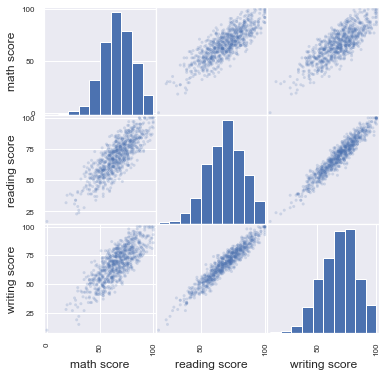

In [157]:
from pandas.plotting import scatter_matrix
scatter_matrix(data, alpha=0.2, figsize=(6, 6))
plt.show()

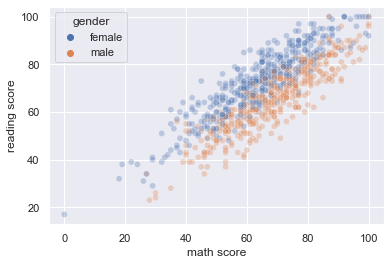

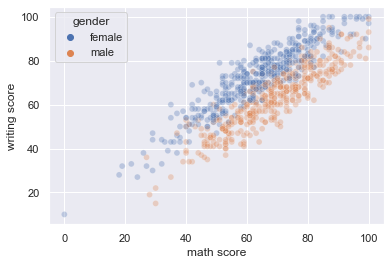

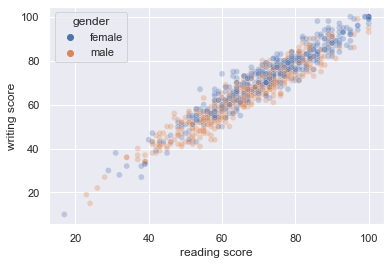

In [159]:
plt.figure()
sns_plot1 = sns.scatterplot(x=data['math score'], \
                            y=data['reading score'], hue = data['gender'], alpha = 0.3).get_figure()
sns_plot1.savefig("output1.png")
plt.figure()
sns_plot2 = sns.scatterplot(x=data['math score'], \
                            y=data['writing score'], hue = data['gender'], alpha = 0.3).get_figure()
sns_plot2.savefig("output2.png")
plt.figure()
sns_plot3 = sns.scatterplot(x=data['reading score'], \
                            y=data['writing score'], hue = data['gender'], alpha = 0.3).get_figure()
sns_plot3.savefig("output3.png")


In [160]:
# add an average mark column for plotting simplicity
data_copy = data.copy()
data_copy['average score'] = (data_copy['math score'] + data_copy['reading score'] + data_copy['writing score'])/3.0
data_copy.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,average score
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


Notes:

 - We can see females receive higher average marks overall
 - Some difference in marks across different ethnicity groups
 - Higher parents level of education is associated with higher average marks
 - Taking the test prep course is associated with higher average marks

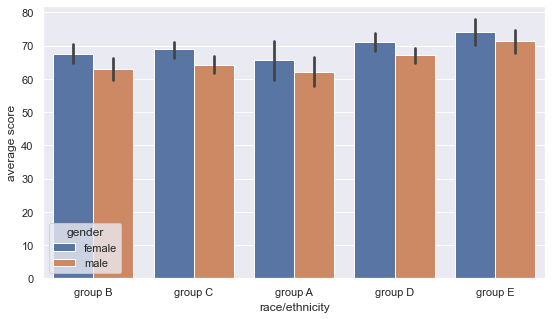

In [161]:
plt.figure(figsize = (9, 5))
sns_plot4 = sns.barplot(x = "race/ethnicity", y = "average score", data = data_copy, hue='gender').get_figure()
sns_plot4.savefig("output4.png")

<AxesSubplot:xlabel='average score', ylabel='parental level of education'>

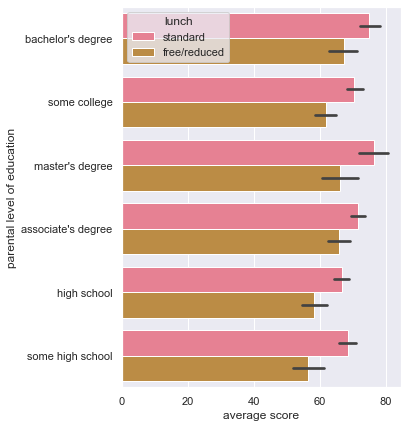

In [98]:
plt.figure(figsize = (5, 7))
sns.barplot(x = "average score", y = "parental level of education",\
            data = data_copy, hue='lunch', orient = "h", palette= sns.color_palette("husl", 8))

 - We will now look at whether the proportion of those receiving standard lunch or free/reduced lunch varies across race
 - From plot below the proportions look similar across all ethnic groups though group E is the only group with a higher proportion of people not receiving free/reduced lunches

In [99]:
agg_data = data_copy.groupby(['lunch','race/ethnicity'])[['lunch']].agg({'lunch': 'count'})
agg_res = agg_data.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
agg_res

lunch
lunch        race/ethnicity           
free/reduced group A         10.144928
             group B         19.927536
             group C         34.420290
             group D         25.000000
             group E         10.507246
standard     group A          7.442748
             group B         19.656489
             group C         31.106870
             group D         27.099237
             group E         14.694656

<AxesSubplot:xlabel='lunch', ylabel='Count'>

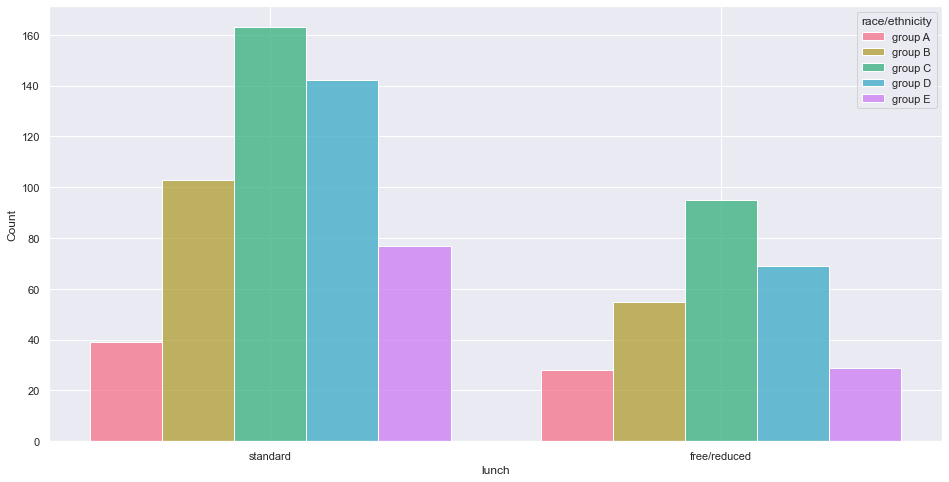

In [100]:
plt.figure(figsize = (16, 8))
hue_order = ['group A', 'group B', 'group C', 'group D', 'group E']
sns.histplot(data=data_copy, x='lunch', hue="race/ethnicity", multiple='dodge',\
             hue_order = hue_order, palette = sns.color_palette("husl", 5), shrink = 0.8)

Now we can look at how the lunch group influences average marks

(note: lunch group potential indicator of socioeconomic status)

<AxesSubplot:xlabel='lunch', ylabel='average score'>

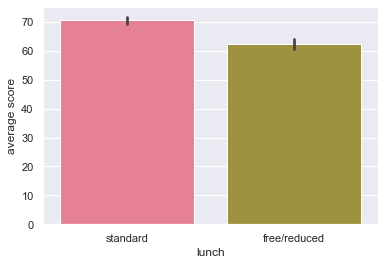

In [101]:
sns.barplot(data=data_copy, x='lunch', y = 'average score', palette = sns.color_palette("husl", 5))

## Model building

- preprocessing -> one hot encode categorical variables
- no numeric predictors
- Build a regressor to predict math, reading and writing scores

In [115]:
# split data set into dependent and independent variables

X_train = data[['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course']]
X_test = data_test[['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course']]
y_train = data[['math score', 'reading score',
       'writing score']]
y_test = data_test[['math score', 'reading score',
       'writing score']]

### Linear Regression Model

In [126]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error

# One hot encode categorical variables
linear_pipeline = Pipeline([
    ('ohc', OneHotEncoder()),
    ('lr', LinearRegression())
])

linear_pipeline.fit(X_train, y_train)

# check if predictions seem reasonable (using 1 example)
y_pred = linear_pipeline.predict(X_test.iloc[1].values.reshape(1, -1))
y_pred

array([[71.26768372, 69.22923602, 67.69734699]])

Lets look at mean absolute error on train set

note: error return is the uniform (non-weighted) average error

In [142]:
y_pred = linear_pipeline.predict(X_test)
error = mean_absolute_error(y_test, y_pred)
error

10.69685448159512

The average error is quite large, looking at the dataframe below we can compare some of the predictions

In [141]:
df = pd.DataFrame(np.concatenate((y_pred, y_test), axis = 1), columns = ["math_pred","reading_pred", "writing_pred",\
                                             "math_test","reading_test", "writing_test"])
df.head(5)

,math_pred,reading_pred,writing_pred,math_test,reading_test,writing_test
0,71.267684,69.229236,67.697347,67.0,73.0,68.0
1,71.267684,69.229236,67.697347,76.0,80.0,73.0
2,72.699628,76.409432,74.902693,87.0,94.0,95.0
3,63.343301,70.122613,69.211441,82.0,85.0,87.0
4,63.800871,71.052960,70.405205,73.0,76.0,78.0


Look at a scatter of the predictions vs actual

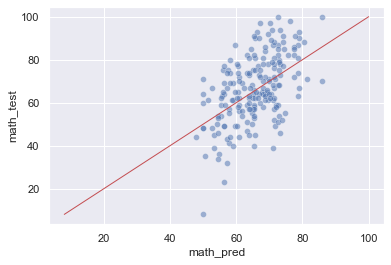

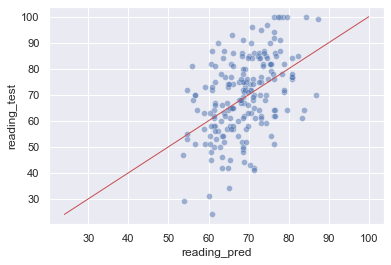

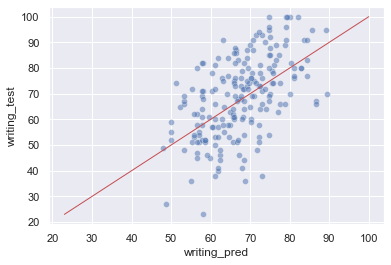

In [152]:
def equalityline(x, y, plt):
    mn = min(x.min(), y.min())
    mx = max(x.max(), y.max())
    points = np.linspace(mn, mx, 100)
    plt.gca().plot(points, points, color='r', marker=None,
            linestyle='-', linewidth=1.0)


plt.figure()
sns.scatterplot(x=df['math_pred'], y=df['math_test'], alpha = 0.5)
equalityline(df['math_pred'], df['math_test'], plt)
plt.figure()
sns.scatterplot(x=df['reading_pred'], y=df['reading_test'], alpha = 0.5)
equalityline(df['reading_pred'], df['reading_test'], plt)
plt.figure()
sns.scatterplot(x=df['writing_pred'], y=df['writing_test'], alpha = 0.5)
equalityline(df['writing_pred'], df['writing_test'], plt)

### Conclusion

- EDA and Data visualisation showed the various influences of factors on student performance
- Females typically score higher in reading and writing while males score higher in maths
- Students taking the prep exam performed better
- There was a difference in score between different ethnique groups
- Students receiving aide for lunch performed slightly worse in tests
- Linear regression model produced a poor fit to data (see above)
- Categorical feature variables don't capture enough information about the student to provide and accurate score

### Potential improvements

- Could include a test score as a feature.
- Test different models (though unlikely too improve much without more features)